### Import các thư viện cần thiết 

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error

# Kết nối đến SQL Server

In [2]:
# Khai báo tên server và tên database
server = 'DESKTOP-3OC8L8B' # đổi thành server trong máy của mình
database = 'Group05_DDS'

cnxn = pyodbc.connect(f'DRIVER=SQL Server;SERVER={server};DATABASE={database}')

# Bước 1: Xác định yêu cầu


Mục tiêu:
- Dự đoán AQI (Chỉ số chất lượng không khí) cho các County trong tương lai (ví dụ: Quý 1 - 2024, Tháng 1 - 2024) để giúp các cơ quan quản lý, tổ chức và cộng đồng có thể lên kế hoạch và hành động kịp thời để giảm thiểu tác động của chất lượng không khí xấu.
Các yếu tố liên quan:

Mô hình dự đoán AQI sẽ sử dụng các yếu tố sau để đưa ra dự đoán chính xác:

+ CountyID: Mã County (mỗi County có một chỉ số AQI riêng biệt).
+ AQICategoryID: Mã loại AQI, dùng để phân loại mức độ ô nhiễm không khí (ví dụ: Tốt, Vừa phải, Không tốt cho nhóm nhạy cảm, Xấu, Rất xấu).
+ Month, Quarter, Year: Thời gian cụ thể (tháng, quý và năm) của dữ liệu AQI để mô hình có thể nhận diện các xu hướng theo thời gian.
+ AQICategory: Cấp độ chất lượng không khí dựa trên AQI (ví dụ: Tốt, Vừa phải, Xấu...).
Các yếu tố này sẽ giúp mô hình hiểu rõ hơn về sự biến đổi của chất lượng không khí theo thời gian và County.

Quy trình thực hiện:
+ Dữ liệu: Dữ liệu AQI sẽ được sử dụng làm đầu vào cho mô hình học máy để dự đoán giá trị AQI cho các County và thời gian trong tương lai.

+ Mô hình Dự đoán AQI: Mô hình học máy sẽ sử dụng các yếu tố như CountyID, AQICategoryID, Month, Quarter, Year, và AQICategory để dự đoán giá trị AQI. Mô hình RandomForestRegressor sẽ được áp dụng để học và dự đoán giá trị AQI cho các County trong các kỳ tiếp theo.

+ Dự đoán cho Tháng 01-2024: Sau khi huấn luyện mô hình, chúng ta sẽ sử dụng mô hình andomForestRegressor để dự đoán giá trị AQI cho các county trong các kỳ tiếp theo

Mục tiêu cuối cùng:
- Mô hình sẽ cung cấp các dự đoán về AQI cho các County cụ thể trong các kỳ tiếp theo, giúp các cơ quan quản lý có thể dự đoán và lên kế hoạch ứng phó với các chỉ số chất lượng không khí có thể thay đổi.

# Bước 2: Chuẩn bị dữ liệu

## Fetch data vào các dataframes

Fact_AirQuality

In [3]:
# fetch data trong bảng Fact_AirQuality và lưu trữ nó trong df
cursor = cnxn.cursor()
cursor.execute("SELECT* FROM Fact_AirQuality")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
# Factsales dataframe
df = pd.DataFrame.from_records(rows, columns=columns)
# Hiển thị 5 dòng dữ liệu mẫu để kiểm tra thử
df.head(5)

,AirQualityID,CountyID,AQICategoryID,AQI,DateID,DefiningParameter,DefiningSite,NumberOfSitesReporting
0,269995,2308,21,52,731,PM2.5,39-135-1001,1
1,269996,2332,21,53,731,PM2.5,06-097-0004,3
2,269997,2168,19,26,731,PM2.5,48-013-1090,1
3,269998,2183,21,58,731,PM2.5,48-061-0006,3
4,269999,2177,19,18,731,PM2.5,48-041-1086,1


Dim_AQI_Category

In [4]:
# fetch data trong bảng Dim_AQI_Category và lưu trữ nó trong df_aqi_category
cursor = cnxn.cursor()
cursor.execute("SELECT* FROM Dim_AQI_Category")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
# Factsales dataframe
df_aqi_category = pd.DataFrame.from_records(rows, columns=columns)
# Hiển thị 5 dòng dữ liệu mẫu để kiểm tra thử
df_aqi_category.head(5)

,AQICategoryID,AQICategory
0,19,Good
1,20,Hazardous
2,21,Moderate
3,22,Unhealthy
4,23,Unhealthy for Sensitive Groups


Dim_County

In [5]:
# fetch data trong bảng Dim_County và lưu trữ nó trong df_county
cursor = cnxn.cursor()
cursor.execute("SELECT* FROM Dim_County")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
# Factsales dataframe
df_county = pd.DataFrame.from_records(rows, columns=columns)
# Hiển thị 5 dòng dữ liệu mẫu để kiểm tra thử
df_county.head(5)

,CountyID,CountyName,CountyCode,StateSK,CountyFIPS,Latitude,Longitude,Population,Status
0,2158,Ada,1,1169,16001,43.000000,-116.000000,497494,None
1,2159,Adair,1,1174,40001,35.000000,-94.000000,19726,None
2,2160,Adams,1,1164,8001,39.000000,-104.000000,520149,None
3,2161,Adams,1,1170,17001,39.000000,-91.000000,65583,None
4,2162,Alameda,1,1163,6001,37.000000,-121.000000,1663823,None


Dim_Date

In [6]:
# fetch data trong bảng Dim_date và lưu trữ nó trong df_date
cursor = cnxn.cursor()
cursor.execute("SELECT* FROM Dim_date")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
# Factsales dataframe
df_date = pd.DataFrame.from_records(rows, columns=columns)
# Hiển thị 5 dòng dữ liệu mẫu để kiểm tra thử
df_date.head(5)

,DateID,Date,Day,Month,Quarter,Year
0,731,2021-01-01,1,1,1,2021
1,732,2021-01-02,2,1,1,2021
2,733,2021-01-03,3,1,1,2021
3,734,2021-01-04,4,1,1,2021
4,735,2021-01-05,5,1,1,2021


Dim_State

In [7]:
# fetch data trong bảng Dim_state và lưu trữ nó trong df_state
cursor = cnxn.cursor()
cursor.execute("SELECT* FROM Dim_state")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
# Factsales dataframe
df_state = pd.DataFrame.from_records(rows, columns=columns)
# Hiển thị 5 dòng dữ liệu mẫu để kiểm tra thử
df_state.head(5)

,StateSK,StateID,StateName,StateCode,Status
0,1159,AK,Alaska,2,Current
1,1160,AL,Alabama,1,Current
2,1161,AR,Arkansas,5,Current
3,1162,AZ,Arizona,4,Current
4,1163,CA,California,6,Current


## EDA: Khai phá dữ liệu

In [8]:
# Kiểu dữ liệu của df
df.dtypes

AirQualityID               int64
CountyID                   int64
AQICategoryID              int64
AQI                        int64
DateID                     int64
DefiningParameter         object
DefiningSite              object
NumberOfSitesReporting     int64
dtype: object

In [9]:
# Tìm missing value trong df
df.isnull().sum()

AirQualityID              0
CountyID                  0
AQICategoryID             0
AQI                       0
DateID                    0
DefiningParameter         0
DefiningSite              0
NumberOfSitesReporting    0
dtype: int64

### Distribution of AQI

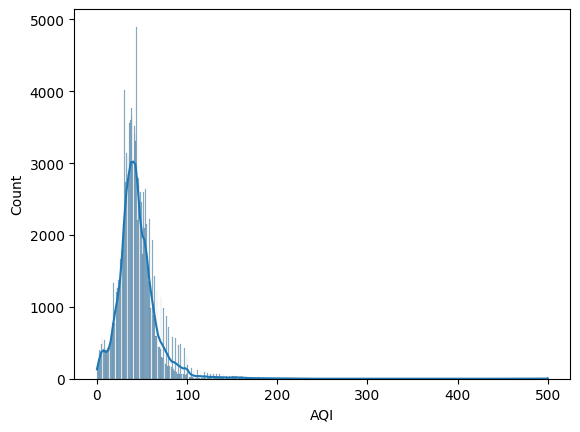

In [10]:
sns.histplot(df['AQI'], kde=True)
plt.show()

Ta thấy rằng giá trị của AQI của nằm trong khoảng từ 0 đến 100 là phổ biến nhất, từ đó ta đưa ra mô hình dự đoán để dự đoán chất lượng không khí

# Bước 3: Lựa chọn mô hình, dự đoán chất lượng không khí trong 01/2024

## Huấn luyện mô hình và tiến hành dự đoán chất lượng không khí trong 01/2024 của 205 County

In [11]:
# Kết hợp các DataFrame để tạo ra dataset cuối cùng sử dụng cho mô hình dự đoán
df_combined = df.merge(df_aqi_category, on='AQICategoryID', how='left')
df_combined = df_combined.merge(df_county, on='CountyID', how='left')
df_combined = df_combined.merge(df_date, on='DateID', how='left')

# Tiền xử lý dữ liệu
df_combined['Date'] = pd.to_datetime(df_combined['Date'], format='%Y-%m-%d')
df_combined['Month'] = df_combined['Date'].dt.month
df_combined['Quarter'] = df_combined['Date'].dt.quarter
df_combined['Year'] = df_combined['Date'].dt.year

# Lọc dữ liệu để huấn luyện (dữ liệu từ trước năm 2024)
train_data = df_combined[df_combined['Year'] < 2024]

# Đặc trưng đầu vào (X) và nhãn đầu ra (y)
features = ['CountyID', 'AQICategoryID', 'Month', 'Quarter', 'Population', 'Latitude', 'Longitude']
X_train = train_data[features]
y_train = train_data['AQI']

# Huấn luyện mô hình Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Trích xuất độ quan trọng của các features
feature_importances = model.feature_importances_

# Tạo DataFrame để hiển thị độ quan trọng của các features
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Tạo dữ liệu giả định cho tháng 1 năm 2024
months_2024 = [1] * len(df_county)  # Tất cả là tháng 1
quarters_2024 = [1] * len(df_county)  # Tháng 1 là Quý 1
years_2024 = [2024] * len(df_county)  # Tất cả là năm 2024

# Tạo dữ liệu giả định cho tháng 1 năm 2024
df_2024 = df_county.copy()  # Sử dụng các thông tin quận có sẵn
df_2024['Month'] = months_2024
df_2024['Quarter'] = quarters_2024
df_2024['Year'] = years_2024
df_2024['AQICategoryID'] = df_2024['CountyID'].map(df_combined.set_index('CountyID')['AQICategoryID'].to_dict())  # Lấy AQICategoryID của mỗi quận

# Đặc trưng đầu vào cho tháng 1 năm 2024
X_2024 = df_2024[features]

# Dự đoán AQI cho tháng 1 năm 2024
y_pred_2024 = model.predict(X_2024)

# Hiển thị toàn bộ kết quả dự đoán cho tháng 1 năm 2024
df_2024['AQI_Predicted'] = y_pred_2024

# Đặt cấu hình hiển thị của Pandas để hiển thị toàn bộ dữ liệu
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các dòng
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột

# Kết hợp thông tin AQI Category từ bảng Dim_AQI_Category vào kết quả dự đoán
df_2024_with_category = df_2024.merge(df_aqi_category[['AQICategoryID', 'AQICategory']], 
                                      on='AQICategoryID', 
                                      how='left')

# Hiển thị toàn bộ kết quả với thêm cột AQI_Category
print(df_2024_with_category[['CountyID', 'AQICategoryID', 'AQICategory', 'Month', 'Year', 'AQI_Predicted']])

# Đánh giá mô hình trên tập huấn luyện (dùng MAE và RMSE)
y_train_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))


     CountyID  AQICategoryID AQICategory  Month  Year  AQI_Predicted
0        2158             21    Moderate      1  2024      72.198611
1        2159             19        Good      1  2024      39.806492
2        2160             19        Good      1  2024      40.683774
3        2161             19        Good      1  2024      32.925508
4        2162             19        Good      1  2024      39.578110
5        2163             19        Good      1  2024      39.260696
6        2164             19        Good      1  2024      34.500504
7        2165             19        Good      1  2024      27.407403
8        2166             19        Good      1  2024      21.487333
9        2167             19        Good      1  2024      38.634707
10       2168             21    Moderate      1  2024      55.030948
11       2169             19        Good      1  2024      31.586329
12       2170             19        Good      1  2024      37.559290
13       2171             21    Mo

# Bước 4: Đánh giá mô hình dự đoán

In [12]:
print(f"\nModel Evaluation on Training Data:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Model Evaluation on Training Data:
Mean Absolute Error (MAE): 7.431230618020042
Root Mean Squared Error (RMSE): 9.588454576940821


## Đánh giá Mô hình Dự đoán Chất lượng Không khí
Mô hình dự đoán chất lượng không khí của chúng tôi đã được đánh giá qua hai chỉ số quan trọng: Mean Absolute Error (MAE) và Root Mean Squared Error (RMSE). Kết quả thu được cho thấy mô hình có thể hoạt động tốt trong việc dự đoán xu hướng chung của chất lượng không khí, tuy nhiên vẫn có một số yếu tố cần cải thiện để đạt được độ chính xác cao hơn trong các tình huống đặc biệt.

### 1. Mean Absolute Error (MAE):
MAE = 7.43 cho thấy sai số trung bình giữa giá trị thực tế và giá trị dự đoán là khoảng 7.43 điểm AQI. Đây là mức sai số hợp lý trong bối cảnh dự đoán chất lượng không khí, vì AQI có thể dao động lớn tùy thuộc vào các yếu tố môi trường và thời tiết. Mức độ sai số này là chấp nhận được nếu mục đích của mô hình chỉ là dự báo tổng quát về chất lượng không khí mà không yêu cầu chính xác tuyệt đối từng điểm.

### 2. Root Mean Squared Error (RMSE):
RMSE = 9.59 cho thấy độ lệch bình quân của mô hình giữa giá trị thực tế và giá trị dự đoán là khoảng 9.59 điểm AQI. RMSE có xu hướng phản ánh sai số lớn hơn khi có các điểm dữ liệu có sự khác biệt lớn (outliers), và trong trường hợp này, mô hình có thể không hoàn toàn chính xác đối với các tình huống ô nhiễm cực kỳ cao hoặc thấp.

### 3. Đánh giá chung:
Mô hình dự đoán chất lượng không khí hoạt động tương đối tốt, với mức độ sai số trung bình và độ lệch bình quân phù hợp với các ứng dụng dự đoán khí tượng và môi trường. Tuy nhiên, nếu yêu cầu về độ chính xác cao hơn, đặc biệt là trong các trường hợp ô nhiễm nguy hiểm , mô hình hiện tại vẫn có thể cần cải thiện.

### 4. Cải tiến mô hình:
- Xử lý outliers: RMSE có thể bị ảnh hưởng mạnh mẽ bởi các giá trị ngoài rìa. Việc xử lý hoặc loại bỏ các điểm dữ liệu cực đoan có thể giúp giảm sai số và cải thiện độ chính xác của mô hình.
- Thêm các yếu tố môi trường: Chất lượng không khí chịu ảnh hưởng của nhiều yếu tố khác như gió, độ ẩm, hoặc các hoạt động công nghiệp. Việc bổ sung thêm các yếu tố này vào mô hình có thể giúp dự đoán chính xác hơn.
- Sử dụng các mô hình phức tạp hơn: Các mô hình phức tạp như Random Forest, Gradient Boosting, hoặc Deep Learning có thể mang lại độ chính xác cao hơn, đặc biệt trong các tình huống có dữ liệu phức tạp.

### 5. Kết luận:
Mô hình hiện tại có thể được coi là hiệu quả với MAE = 7.43 và RMSE = 9.59, nhưng để cải thiện độ chính xác trong các tình huống ô nhiễm cao hoặc cực đoan, mô hình cần được tinh chỉnh thêm. Các phương pháp cải tiến như xử lý outliers, thêm biến môi trường, hoặc thử nghiệm các mô hình phức tạp hơn có thể giúp nâng cao độ chính xác và độ tin cậy của mô hình trong dự đoán chất lượng không khí.



## Feature Importances

In [13]:
# In ra độ quan trọng của các features
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
         Feature  Importance
0       CountyID    0.016808
1  AQICategoryID    0.904783
2          Month    0.016175
3        Quarter    0.003476
4     Population    0.021447
5       Latitude    0.014306
6      Longitude    0.023005


### Đánh giá kết quả Độ Quan Trọng của Các Feature trong Mô Hình Dự Đoán AQI cho các County trong tương lai

Sau quá trình xây dựng mô hình RandomForestRegression để dự đoán AQI trong tương lai của các County, Mô hình đã tính toán và đánh giá độ quan trọng của các feature đầu vào. Kết quả thu được như sau:

- AQICategoryID (Độ quan trọng: 0.904783): Đây là feature có độ quan trọng cao nhất trong mô hình, chiếm tới hơn 90% tầm ảnh hưởng trong việc dự đoán AQI. Điều này cho thấy rằng, nhóm phân loại AQI (AQICategoryID) là yếu tố quyết định chủ yếu trong việc ước tính chỉ số chất lượng không khí tại các quận.

- CountyID (Độ quan trọng: 0.016808): Mặc dù có mặt trong mô hình, độ quan trọng của CountyID rất thấp. Điều này cho thấy rằng thông tin về County không có ảnh hưởng mạnh mẽ đối với việc dự đoán AQI, có thể vì sự tương đồng giữa các County hoặc sự phụ thuộc vào các yếu tố khác như mức độ ô nhiễm.

- Population (Độ quan trọng: 0.021447): Dân số của quận có độ quan trọng nhẹ, có thể ảnh hưởng đến AQI thông qua các yếu tố như mật độ giao thông, mức độ ô nhiễm từ hoạt động công nghiệp hoặc sinh hoạt.

- Latitude (Độ quan trọng: 0.014306) và Longitude (Độ quan trọng: 0.023005): Vị trí địa lý của các quận, thể hiện qua kinh độ và vĩ độ, cũng có ảnh hưởng không lớn trong việc dự đoán AQI, điều này có thể do mô hình không tính đến các yếu tố môi trường toàn cầu mà chỉ tập trung vào các yếu tố trực tiếp.

- Month (Độ quan trọng: 0.016175) và Quarter (Độ quan trọng: 0.003476): Các yếu tố thời gian như tháng trong năm và quý có ảnh hưởng ít đến việc dự đoán AQI, điều này có thể do AQI chủ yếu phụ thuộc vào các yếu tố môi trường, khí hậu thay vì chu kỳ thời gian.

#### Kết luận: 
Mô hình RandomForestRegression cho thấy rằng nhóm phân loại AQI (AQICategoryID) đóng vai trò quan trọng nhất trong việc dự đoán chất lượng không khí tại các quận. Các yếu tố khác như mã quận, dân số, vị trí địa lý và thời gian có ảnh hưởng thấp hơn. 